In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fhir_client import FHIRClient
import logging
import pandas as pd

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

client = FHIRClient(service_base_url='https://r3.smarthealthit.org', logger=None)

INFO:root:Processor ObservationLatestBmiProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestBmiProcessor
INFO:root:Name of patient processor will be PatientbmiLatestProcessor
INFO:root:Processor PatientbmiLatestProcessor added.
INFO:root:Processor ObservationLatestHeightProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestHeightProcessor
INFO:root:Name of patient processor will be PatientheightLatestProcessor
INFO:root:Processor PatientheightLatestProcessor added.
INFO:root:Processor ObservationLatestWeightProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestWeightProcessor
INFO:root:Name of patient processor will be PatientweightLatestProcessor
INFO:root:Processor PatientweightLatestProcessor added.


## Querying Patients
There are two general ways of searching for patients with specific properties.

The first one is to search by coding system:

In [3]:
procedures = client.get_all_procedures()
pd.DataFrame([prod.code['coding'][0] for prod in procedures]).drop_duplicates().sort_values(by=['display']).head()

,code,display,system
893,183450002,Admission to burn unit,http://snomed.info/sct
1911,305340004,Admission to long stay hospital,http://snomed.info/sct
83,305428000,Admission to orthopedic department,http://snomed.info/sct
6217,305433001,Admission to trauma surgery department,http://snomed.info/sct
13687,35637008,Alcohol rehabilitation,http://snomed.info/sct


In [4]:
patients_by_procedure_code = client.get_patients_by_procedure_code("http://snomed.info/sct","73761001")
"Retrieved {} patients with a total of {} observations".format( len(patients_by_procedure_code), 
                                                               sum([len(pat.observations) for pat in patients_by_procedure_code]))

'Retrieved 252 patients with a total of 23145 observations'

The second one is by text. The searched text will be `CodeableConcept.text`, `Coding.display`, or `Identifier.type.text`:

In [5]:
conditions = client.get_all_conditions()
pd.DataFrame([cond.code['coding'][0] for cond in conditions]).drop_duplicates(subset=['display']).sort_values(by='display', ascending=True).head()

,code,display,system
486,30473006,Abdominal pain,http://snomed.info/sct
138,102594003,Abnormal ECG,http://snomed.info/sct
6800,26079004,Abnormal involuntary movement,http://snomed.info/sct
6275,168750009,"Abnormal mammogram, unspecified",http://snomed.info/sct
6568,312399001,Abnormal results of thyroid function studies,http://snomed.info/sct


In [6]:
pd.DataFrame([cond.code['coding'][0] for cond in conditions])

,code,display,system
0,443165006,Pathological fracture due to osteoporosis (dis...,http://snomed.info/sct
1,36971009,Sinusitis (disorder),http://snomed.info/sct
2,195662009,Acute viral pharyngitis (disorder),http://snomed.info/sct
3,193590000,Mature cataract,http://snomed.info/sct
4,197927001,Recurrent urinary tract infection,http://snomed.info/sct
5,201834006,"Localized, primary osteoarthritis of the hand",http://snomed.info/sct
6,75498004,Acute bacterial sinusitis (disorder),http://snomed.info/sct
7,15777000,Prediabetes,http://snomed.info/sct
8,39848009,Whiplash injury to neck,http://snomed.info/sct
9,87433001,Pulmonary emphysema (disorder),http://snomed.info/sct


In [6]:
patients_by_condition_text = client.get_patients_by_condition_text("Abdominal pain")
"Retrieved {} patients with a total of {} observations".format( len(patients_by_condition_text), 
                                                               sum([len(pat.observations) for pat in patients_by_condition_text]))


'Retrieved 4 patients with a total of 581 observations'

One can also load a control group for a specific cohort of patients. The control group is of equal size of the case cohort (min size: 10) and is composed of randomly sampled patients that do not match the original query. Their class is contained in the `.case` property of the Patient object.

In [3]:
patients_by_condition_text_with_controls = client.get_patients_by_condition_text("Abdominal pain", controls=True)
print("Retrieved {} patients with a total of {} observations".format( len(patients_by_condition_text_with_controls), 
                                                               sum([len(pat.observations) for pat in patients_by_condition_text_with_controls])))
print("{} are cases and {} are controls".format(len([d for d in patients_by_condition_text_with_controls if d.case]), 
                                                len([d for d in patients_by_condition_text_with_controls if not d.case])))

INFO:root:Loaded 1628 patients IDs.


Retrieved 14 patients with a total of 836 observations
4 are cases and 10 are controls


## Machine Learning

In [9]:
from ml_on_fhir import MLOnFHIRClassifier
from fhir_objects.patient import Patient
from sklearn.tree import DecisionTreeClassifier

ml_fhir = MLOnFHIRClassifier(Patient, feature_attrs=['birthDate'],
                             label_attrs=['gender'], preprocessor=client.preprocessor)
X, y, trained_clf = ml_fhir.fit(patients_by_condition_text, DecisionTreeClassifier())

from sklearn.metrics import accuracy_score, roc_curve, auc
fpr, tpr, _ = roc_curve(y, trained_clf.predict(X))
print("Prediction accuracy {}".format( auc(fpr, tpr) ) )

INFO:root:Extracting attributes from data set
INFO:root:Preprocessing data
INFO:root:Started training of clf
INFO:root:Training completed
INFO:root:Accuracy : 1.0, F1-score : 1.0


Prediction accuracy 1.0


Let's take a more realistic setup with cases and controls.

In [12]:
ml_fhir = MLOnFHIRClassifier(Patient, feature_attrs=['birthDate', 'gender'],
                             label_attrs=['case'], preprocessor=client.preprocessor)
X, y, trained_clf = ml_fhir.fit(patients_by_condition_text_with_controls, DecisionTreeClassifier())

from sklearn.metrics import accuracy_score, roc_curve, auc
fpr, tpr, _ = roc_curve(y, trained_clf.predict(X))
print("Prediction accuracy {}".format( auc(fpr, tpr) ) )

INFO:root:Extracting attributes from data set
INFO:root:Preprocessing data
INFO:root:Started training of clf
INFO:root:Training completed
INFO:root:Accuracy : 1.0, F1-score : 1.0


Prediction accuracy 1.0


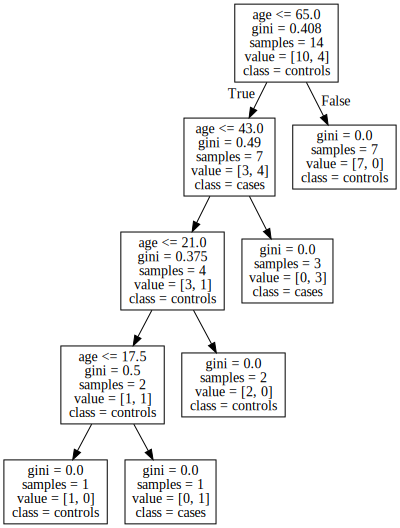

In [14]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(ml_fhir.clf, out_file=None,
                               feature_names=['age', 'gender'],
                               class_names={0:'controls', 1:'cases'})
graph = graphviz.Source(dot_data)
graph

## Custom Preprocessing Classes

#### The first five values of the ` birthDate` feature that has been preprocessed into an age in years:

In [15]:
X[:5]

array([[19,  0],
       [64,  1],
       [53,  1],
       [55,  0],
       [16,  0]])

If you want to preprocess a patient differently, feel free to implement your own preprocessing class. 
We can use the `register_patient_preprocessor` function to do so. It is crucial to stick to the following naming scheme: 
    
    "Patient<FHIR_Resource_Name>Processor"
    
Furthemore, at least the methods `fit` and `transform` have to be implemented.

In [17]:
from preprocessing import Preprocessing

from sklearn.base import BaseEstimator
import datetime as dt
import numpy as np
from fhir_objects.fhir_resources import date_format

class PatientbirthDateProcessor(BaseEstimator):
    """
    Calculates the age in days to use birthdate as a feature 
    """
    def transform(self, X, **transform_params):
        ages = []
        for birthdate in X:
            b_date = dt.datetime.strptime(birthdate[0], date_format)
            ages.append([int(
                            (dt.datetime.now().date() - b_date.date()).days)])
        return np.array(ages)

    def fit(self, X, y=None, **fit_params):
        return self
    
preprocessor = Preprocessing()
preprocessor.register_patient_preprocessor(PatientbirthDateProcessor)

INFO:root:Processor ObservationLatestBmiProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestBmiProcessor
INFO:root:Name of patient processor will be PatientbmiLatestProcessor
INFO:root:Processor PatientbmiLatestProcessor added.
INFO:root:Processor ObservationLatestHeightProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestHeightProcessor
INFO:root:Name of patient processor will be PatientheightLatestProcessor
INFO:root:Processor PatientheightLatestProcessor added.
INFO:root:Processor ObservationLatestWeightProcessor added.
INFO:root:Adding Patient Processor for ObservationLatestWeightProcessor
INFO:root:Name of patient processor will be PatientweightLatestProcessor
INFO:root:Processor PatientweightLatestProcessor added.
INFO:root:Processor PatientbirthDateProcessor added.


In [18]:
ml_fhir = MLOnFHIRClassifier(Patient, feature_attrs=['birthDate'], label_attrs=['gender'], preprocessor=preprocessor)
X, y, trained_clf = ml_fhir.fit(patients_by_condition_text, DecisionTreeClassifier())

INFO:root:Extracting attributes from data set
INFO:root:Preprocessing data
INFO:root:Started training of clf
INFO:root:Training completed
INFO:root:Accuracy : 1.0, F1-score : 1.0


#### The `birthDate` feature is now the age in days:

In [19]:
X[:5]

array([[ 7074],
       [23619],
       [19661],
       [20179]])